# **DATA PREPROCESSING BASED ON EDA INSIGHTS**

This notebook implements preprocessing steps based on the comprehensive EDA findings and recommendations. We'll follow the evidence-based approach from the EDA report to ensure our preprocessing aligns with the data patterns discovered.
Based on the EDA report, we will:

1. **Feature Engineering** - `Age_of_estab, Annual_wage, wage_per_hour, wage_per_week, wage_per_month, wage_per_year, need_training-has_exp, need_training_no_exp, region_median_wage, wage_vs_region`.
2. **Handle Skewed Variables(Log Tranformation)** - `No_of_employees, year_of_estab, and prevailing_wage`.
3. **Encoding categorical and Ordinal columns** - `binary conding on all the yes and No columns, `
4. **Splitting into target and Features / Feature Selection** 
6. **Target Handling** - Class imbalance using SMOTE
7. **Scaling** - RobustScaler
8. **Feature Importance Analysis**


**Key EDA Evidence to Implement**
- **Skewed variables**:  (log-transform)
- **Feature engineering**: `Age_of_estab, wage_per_hour, age_per_year`.

#### **Import Libraries and load the data**

In [1]:
# Core libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import LabelEncoder, RobustScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix


# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print('All libraries imported successfully')


All libraries imported successfully


In [2]:
# Load the dataset
df_visa = pd.read_csv('df_visa.csv')

df_visa.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [3]:
# Create a copy of the dataset
df_processed = df_visa.copy()

#### 1. **Feature Engineering** 
- age_of_estab
- annual_wage (wage_per_hour, wage_per_week, wage_per_month, wage_per_year)
- need_training_has_exp
- need_training_no_exp
- region_median_wage
- wage_vs_region.

In [4]:
# Check the columns
df_processed.columns

Index(['continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'no_of_employees', 'yr_of_estab',
       'region_of_employment', 'prevailing_wage', 'unit_of_wage',
       'full_time_position', 'case_status'],
      dtype='object')

In [5]:
# Feature Engineering
print("FEATURE ENGINEERING BASED ON EDA RECOMMENDATIONS")

# Generate the current year
current_yr = datetime.now().year

# check the age of establishment
df_processed['age_of_estab'] = current_yr - df_processed['yr_of_estab']
df_processed.head(5)

FEATURE ENGINEERING BASED ON EDA RECOMMENDATIONS


,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,age_of_estab
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20


In [6]:
# Calculate the annual wage
unit_map = {
    'Hour': 2080, # 40* 52
    'Week': 52,
    'Month': 12,
    'Year': 1
}

df_processed['annual_wage'] = df_processed['prevailing_wage'] * df_processed['unit_of_wage'].map(unit_map)
df_processed['wage_per_hour'] = df_processed['annual_wage'] / 2080
df_processed['wage_per_week'] = df_processed['annual_wage'] / 52
df_processed['wage_per_month'] = df_processed['annual_wage'] / 12
df_processed.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,age_of_estab,annual_wage,wage_per_hour,wage_per_week,wage_per_month
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18,1231782.032,592.202900,23688.116000,102648.502667
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23,83425.650,40.108486,1604.339423,6952.137500
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17,122996.860,59.133106,2365.324231,10249.738333
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128,83434.030,40.112514,1604.500577,6952.835833
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20,149907.390,72.070861,2882.834423,12492.282500


In [7]:
# Need training has experience
df_processed['need_training_has_exp'] = ((df_processed['has_job_experience'] == 'Y') & (df_processed['requires_job_training'] == 'Y')).astype(int)
df_processed.head(320)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,age_of_estab,annual_wage,wage_per_hour,wage_per_week,wage_per_month,need_training_has_exp
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18,1231782.032,592.202900,23688.116000,102648.502667,0
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23,83425.650,40.108486,1604.339423,6952.137500,0
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17,122996.860,59.133106,2365.324231,10249.738333,0
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128,83434.030,40.112514,1604.500577,6952.835833,0
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20,149907.390,72.070861,2882.834423,12492.282500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,Asia,High School,Y,N,2170,1998,Midwest,115801.0900,Year,Y,Certified,27,115801.090,55.673601,2226.944038,9650.090833,0
316,North America,High School,Y,N,3550,2012,West,268.1379,Hour,Y,Certified,13,557726.832,268.137900,10725.516000,46477.236000,0
317,South America,Bachelor's,N,N,1761,1995,Midwest,667.4133,Hour,Y,Certified,30,1388219.664,667.413300,26696.532000,115684.972000,0
318,Asia,High School,N,N,805,1898,Northeast,117.8500,Hour,Y,Denied,127,245128.000,117.850000,4714.000000,20427.333333,0


In [8]:
# Need training has no experience
df_processed['need_training_no_exp'] = ((df_processed['has_job_experience'] == 'N') & (df_processed['requires_job_training'] == 'Y')).astype(int)
df_processed.head(320)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,age_of_estab,annual_wage,wage_per_hour,wage_per_week,wage_per_month,need_training_has_exp,need_training_no_exp
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18,1231782.032,592.202900,23688.116000,102648.502667,0,0
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23,83425.650,40.108486,1604.339423,6952.137500,0,0
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17,122996.860,59.133106,2365.324231,10249.738333,0,1
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128,83434.030,40.112514,1604.500577,6952.835833,0,0
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20,149907.390,72.070861,2882.834423,12492.282500,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,Asia,High School,Y,N,2170,1998,Midwest,115801.0900,Year,Y,Certified,27,115801.090,55.673601,2226.944038,9650.090833,0,0
316,North America,High School,Y,N,3550,2012,West,268.1379,Hour,Y,Certified,13,557726.832,268.137900,10725.516000,46477.236000,0,0
317,South America,Bachelor's,N,N,1761,1995,Midwest,667.4133,Hour,Y,Certified,30,1388219.664,667.413300,26696.532000,115684.972000,0,0
318,Asia,High School,N,N,805,1898,Northeast,117.8500,Hour,Y,Denied,127,245128.000,117.850000,4714.000000,20427.333333,0,0


In [9]:
# Region median wage
df_processed['region_median_wage'] = df_processed.groupby('region_of_employment')['annual_wage'].transform('median')
df_processed.head(320)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,age_of_estab,annual_wage,wage_per_hour,wage_per_week,wage_per_month,need_training_has_exp,need_training_no_exp,region_median_wage
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18,1231782.032,592.202900,23688.116000,102648.502667,0,0,73867.56
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23,83425.650,40.108486,1604.339423,6952.137500,0,0,81428.85
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17,122996.860,59.133106,2365.324231,10249.738333,0,1,73867.56
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128,83434.030,40.112514,1604.500577,6952.835833,0,0,73867.56
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20,149907.390,72.070861,2882.834423,12492.282500,0,0,84812.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,Asia,High School,Y,N,2170,1998,Midwest,115801.0900,Year,Y,Certified,27,115801.090,55.673601,2226.944038,9650.090833,0,0,94520.54
316,North America,High School,Y,N,3550,2012,West,268.1379,Hour,Y,Certified,13,557726.832,268.137900,10725.516000,46477.236000,0,0,73867.56
317,South America,Bachelor's,N,N,1761,1995,Midwest,667.4133,Hour,Y,Certified,30,1388219.664,667.413300,26696.532000,115684.972000,0,0,94520.54
318,Asia,High School,N,N,805,1898,Northeast,117.8500,Hour,Y,Denied,127,245128.000,117.850000,4714.000000,20427.333333,0,0,81428.85


In [10]:
# Wage vs region (show the ratio of how the employees wage compares to their regional median wage)

df_processed['wage_vs_region'] = df_processed['annual_wage'] / df_processed['region_median_wage']
df_processed.head(320)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,age_of_estab,annual_wage,wage_per_hour,wage_per_week,wage_per_month,need_training_has_exp,need_training_no_exp,region_median_wage,wage_vs_region
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18,1231782.032,592.202900,23688.116000,102648.502667,0,0,73867.56,16.675548
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23,83425.650,40.108486,1604.339423,6952.137500,0,0,81428.85,1.024522
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17,122996.860,59.133106,2365.324231,10249.738333,0,1,73867.56,1.665100
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128,83434.030,40.112514,1604.500577,6952.835833,0,0,73867.56,1.129508
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20,149907.390,72.070861,2882.834423,12492.282500,0,0,84812.35,1.767518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,Asia,High School,Y,N,2170,1998,Midwest,115801.0900,Year,Y,Certified,27,115801.090,55.673601,2226.944038,9650.090833,0,0,94520.54,1.225142
316,North America,High School,Y,N,3550,2012,West,268.1379,Hour,Y,Certified,13,557726.832,268.137900,10725.516000,46477.236000,0,0,73867.56,7.550362
317,South America,Bachelor's,N,N,1761,1995,Midwest,667.4133,Hour,Y,Certified,30,1388219.664,667.413300,26696.532000,115684.972000,0,0,94520.54,14.686963
318,Asia,High School,N,N,805,1898,Northeast,117.8500,Hour,Y,Denied,127,245128.000,117.850000,4714.000000,20427.333333,0,0,81428.85,3.010334


#### 2. **Log-Transform Skewed Variables (EDA Recommendation)**

In [11]:
# # Log-transfrorm skewed varibales as recommended by EDA
def handle_skewed_var(df):
    # Variables to log-transform based on EDA findings
    skewed_var = ['annual_wage','wage_per_hour','wage_per_week', 'wage_per_month', 'age_of_estab', 'wage_vs_region']
    for var in skewed_var:
            # Checks if variable has zero or negative values
        min_val = df_processed[var].min()
        if min_val <=0:
            # Use log1p for variables with zeros
            df_processed[f'{var}_log'] = np.log1p(df_processed[var])
            print(f'✓ {var}: Applied log1p transformation (had {min_val:.3f} minimum value)')

        else:
            # Use log for positive values only
            df_processed[f'{var}_log'] = np.log(df_processed[var])
            print(f"✓ {var}: Applied log transformation")

        # Check for skewness before and after
        original_skew = skew(df_processed[var])
        transformed_skew = skew(df_processed[f'{var}_log'])
        print(f" Original Skewness: {original_skew:.3f} -> Transformed skewness: {transformed_skew:.3f}")
    return df

In [12]:
handle_skewed_var(df_processed)

✓ annual_wage: Applied log transformation
 Original Skewness: 8.976 -> Transformed skewness: 0.014
✓ wage_per_hour: Applied log transformation
 Original Skewness: 8.976 -> Transformed skewness: 0.014
✓ wage_per_week: Applied log transformation
 Original Skewness: 8.976 -> Transformed skewness: 0.014
✓ wage_per_month: Applied log transformation
 Original Skewness: 8.976 -> Transformed skewness: 0.014
✓ age_of_estab: Applied log transformation
 Original Skewness: 2.037 -> Transformed skewness: 0.812
✓ wage_vs_region: Applied log transformation
 Original Skewness: 9.194 -> Transformed skewness: 0.043


,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,...,need_training_has_exp,need_training_no_exp,region_median_wage,wage_vs_region,annual_wage_log,wage_per_hour_log,wage_per_week_log,wage_per_month_log,age_of_estab_log,wage_vs_region_log
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,...,0,0,73867.56,16.675548,14.023972,6.383849,10.072729,11.539066,2.890372,2.813943
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,...,0,0,81428.85,1.024522,11.331711,3.691588,7.380467,8.846804,3.135494,0.024226
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,...,0,1,73867.56,1.665100,11.719914,4.079791,7.768670,9.235007,2.833213,0.509885
3,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,...,0,0,73867.56,1.129508,11.331812,3.691688,7.380568,8.846905,4.852030,0.121782
4,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,...,0,0,84812.35,1.767518,11.917773,4.277650,7.966529,9.432866,2.995732,0.569577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25475,Asia,Bachelor's,Y,Y,2601,2008,South,77092.5700,Year,Y,...,1,0,84812.35,0.908978,11.252762,3.612639,7.301518,8.767856,2.833213,-0.095434
25476,Asia,High School,Y,N,3274,2006,Northeast,279174.7900,Year,Y,...,0,0,81428.85,3.428451,12.539593,4.899470,8.588350,10.054687,2.944439,1.232108
25477,Asia,Master's,Y,N,1121,1910,South,146298.8500,Year,N,...,0,0,84812.35,1.724971,11.893407,4.253284,7.942163,9.408500,4.744932,0.545210
25478,Asia,Master's,Y,Y,1918,1887,West,86154.7700,Year,Y,...,1,0,73867.56,1.166341,11.363901,3.723777,7.412657,8.878994,4.927254,0.153872


#### **3. Encoding categorical and Ordinal columns - `binary encoding on all the yes and No columns, `**

In [13]:
# Binary encoding for columns with yes and nos
for col in ['has_job_experience', 'requires_job_training', 'full_time_position']:
    df_processed[col] = (df_processed[col]=='Y').astype(int)

df_processed.head(20)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,...,need_training_has_exp,need_training_no_exp,region_median_wage,wage_vs_region,annual_wage_log,wage_per_hour_log,wage_per_week_log,wage_per_month_log,age_of_estab_log,wage_vs_region_log
0,Asia,High School,0,0,14513,2007,West,592.2029,Hour,1,...,0,0,73867.56,16.675548,14.023972,6.383849,10.072729,11.539066,2.890372,2.813943
1,Asia,Master's,1,0,2412,2002,Northeast,83425.6500,Year,1,...,0,0,81428.85,1.024522,11.331711,3.691588,7.380467,8.846804,3.135494,0.024226
2,Asia,Bachelor's,0,1,44444,2008,West,122996.8600,Year,1,...,0,1,73867.56,1.665100,11.719914,4.079791,7.768670,9.235007,2.833213,0.509885
3,Asia,Bachelor's,0,0,98,1897,West,83434.0300,Year,1,...,0,0,73867.56,1.129508,11.331812,3.691688,7.380568,8.846905,4.852030,0.121782
4,Africa,Master's,1,0,1082,2005,South,149907.3900,Year,1,...,0,0,84812.35,1.767518,11.917773,4.277650,7.966529,9.432866,2.995732,0.569577
5,Asia,Master's,1,0,2339,2012,South,78252.1400,Year,1,...,0,0,84812.35,0.922650,11.267691,3.627568,7.316448,8.782785,2.564949,-0.080505
6,Asia,Bachelor's,0,0,4985,1994,South,53635.3900,Year,1,...,0,0,84812.35,0.632401,10.889964,3.249841,6.938721,8.405058,3.433987,-0.458232
7,North America,Bachelor's,1,0,3035,1924,West,418.2298,Hour,1,...,0,0,73867.56,11.776726,13.676154,6.036031,9.724910,11.191248,4.615121,2.466125
8,Asia,Bachelor's,0,0,4810,2012,Midwest,74362.1900,Year,1,...,0,0,94520.54,0.786730,11.216703,3.576580,7.265459,8.731796,2.564949,-0.239870
9,Europe,Doctorate,1,0,2251,1995,South,67514.7600,Year,1,...,0,0,84812.35,0.796049,11.120102,3.479978,7.168858,8.635195,3.401197,-0.228095


In [14]:
df_processed['education_of_employee'].unique()

array(['High School', "Master's", "Bachelor's", 'Doctorate'], dtype=object)

In [15]:
# Encoding the categorical and ordinal columns
label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder(categories=[["High School", "Bachelor's", "Master's", "Doctorate"]])

df_processed['continent'] = label_encoder.fit_transform(df_processed['continent'])
df_processed['region_of_employment'] = label_encoder.fit_transform(df_processed['region_of_employment'])
df_processed['case_status'] = label_encoder.fit_transform(df_processed['case_status'])
df_processed['education_of_employee'] = ordinal_encoder.fit_transform(df_processed[['education_of_employee']])

In [16]:
df_processed.head(5)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,...,need_training_has_exp,need_training_no_exp,region_median_wage,wage_vs_region,annual_wage_log,wage_per_hour_log,wage_per_week_log,wage_per_month_log,age_of_estab_log,wage_vs_region_log
0,1,0.0,0,0,14513,2007,4,592.2029,Hour,1,...,0,0,73867.56,16.675548,14.023972,6.383849,10.072729,11.539066,2.890372,2.813943
1,1,2.0,1,0,2412,2002,2,83425.6500,Year,1,...,0,0,81428.85,1.024522,11.331711,3.691588,7.380467,8.846804,3.135494,0.024226
2,1,1.0,0,1,44444,2008,4,122996.8600,Year,1,...,0,1,73867.56,1.665100,11.719914,4.079791,7.768670,9.235007,2.833213,0.509885
3,1,1.0,0,0,98,1897,4,83434.0300,Year,1,...,0,0,73867.56,1.129508,11.331812,3.691688,7.380568,8.846905,4.852030,0.121782
4,0,2.0,1,0,1082,2005,3,149907.3900,Year,1,...,0,0,84812.35,1.767518,11.917773,4.277650,7.966529,9.432866,2.995732,0.569577


#### **4. Splitting into target and Features / Feature Selection**

In [17]:
# Splitting into target and Features
y = df_processed['case_status']
X = df_processed.drop('case_status', axis=1)

In [18]:
y

0        1
1        0
2        1
3        1
4        0
        ..
25475    0
25476    0
25477    0
25478    0
25479    0
Name: case_status, Length: 25480, dtype: int64

In [19]:
X

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,...,need_training_has_exp,need_training_no_exp,region_median_wage,wage_vs_region,annual_wage_log,wage_per_hour_log,wage_per_week_log,wage_per_month_log,age_of_estab_log,wage_vs_region_log
0,1,0.0,0,0,14513,2007,4,592.2029,Hour,1,...,0,0,73867.56,16.675548,14.023972,6.383849,10.072729,11.539066,2.890372,2.813943
1,1,2.0,1,0,2412,2002,2,83425.6500,Year,1,...,0,0,81428.85,1.024522,11.331711,3.691588,7.380467,8.846804,3.135494,0.024226
2,1,1.0,0,1,44444,2008,4,122996.8600,Year,1,...,0,1,73867.56,1.665100,11.719914,4.079791,7.768670,9.235007,2.833213,0.509885
3,1,1.0,0,0,98,1897,4,83434.0300,Year,1,...,0,0,73867.56,1.129508,11.331812,3.691688,7.380568,8.846905,4.852030,0.121782
4,0,2.0,1,0,1082,2005,3,149907.3900,Year,1,...,0,0,84812.35,1.767518,11.917773,4.277650,7.966529,9.432866,2.995732,0.569577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25475,1,1.0,1,1,2601,2008,3,77092.5700,Year,1,...,1,0,84812.35,0.908978,11.252762,3.612639,7.301518,8.767856,2.833213,-0.095434
25476,1,0.0,1,0,3274,2006,2,279174.7900,Year,1,...,0,0,81428.85,3.428451,12.539593,4.899470,8.588350,10.054687,2.944439,1.232108
25477,1,2.0,1,0,1121,1910,3,146298.8500,Year,0,...,0,0,84812.35,1.724971,11.893407,4.253284,7.942163,9.408500,4.744932,0.545210
25478,1,2.0,1,1,1918,1887,4,86154.7700,Year,1,...,1,0,73867.56,1.166341,11.363901,3.723777,7.412657,8.878994,4.927254,0.153872


In [20]:
# Drop columns that have 
dropped_cols = ['prevailing_wage', 'unit_of_wage', 'annual_wage','wage_per_hour','wage_per_week', 'wage_per_month', 'age_of_estab', 'wage_vs_region']

X = X.drop(dropped_cols, axis=1)

In [21]:
X

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,full_time_position,need_training_has_exp,need_training_no_exp,region_median_wage,annual_wage_log,wage_per_hour_log,wage_per_week_log,wage_per_month_log,age_of_estab_log,wage_vs_region_log
0,1,0.0,0,0,14513,2007,4,1,0,0,73867.56,14.023972,6.383849,10.072729,11.539066,2.890372,2.813943
1,1,2.0,1,0,2412,2002,2,1,0,0,81428.85,11.331711,3.691588,7.380467,8.846804,3.135494,0.024226
2,1,1.0,0,1,44444,2008,4,1,0,1,73867.56,11.719914,4.079791,7.768670,9.235007,2.833213,0.509885
3,1,1.0,0,0,98,1897,4,1,0,0,73867.56,11.331812,3.691688,7.380568,8.846905,4.852030,0.121782
4,0,2.0,1,0,1082,2005,3,1,0,0,84812.35,11.917773,4.277650,7.966529,9.432866,2.995732,0.569577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25475,1,1.0,1,1,2601,2008,3,1,1,0,84812.35,11.252762,3.612639,7.301518,8.767856,2.833213,-0.095434
25476,1,0.0,1,0,3274,2006,2,1,0,0,81428.85,12.539593,4.899470,8.588350,10.054687,2.944439,1.232108
25477,1,2.0,1,0,1121,1910,3,0,0,0,84812.35,11.893407,4.253284,7.942163,9.408500,4.744932,0.545210
25478,1,2.0,1,1,1918,1887,4,1,1,0,73867.56,11.363901,3.723777,7.412657,8.878994,4.927254,0.153872


#### **5. Target Handling - Class imbalance using SMOTE**

In [22]:
smote = SMOTE(sampling_strategy='minority')
X,y = smote.fit_resample(X,y)
y.value_counts()

case_status
1    17018
0    17018
Name: count, dtype: int64

In [23]:
# Create a copy before scaling
X_copy = X.copy()
y_copy = y.copy()

In [24]:
# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display output
print("Data Split results")
print(f"Train Set: {X_train.shape} ({X_train.shape[0]/len(X)*100:.2f}%)")
print(f"Test Set: {X_test.shape} ({X_test.shape[0]/len(X)*100:.2f}%)")


Data Split results
Train Set: (27228, 17) (80.00%)
Test Set: (6808, 17) (20.00%)


#### **6. Feature Scaling using RobustScaler (EDA Recommendation)**

Apply Robust Scaler as recommended by EDA

In [25]:
# Instantiate RobustScaler
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Check the median to ensure it was scaled
print("RobustScaling applied to train and test set of features!")
print(f"Train set Scaled(Median): {X_train_scaled.median().mean():.4f}")
print(f"Test set Scaled(Median): {X_test_scaled.median().mean():.4f}")

RobustScaling applied to train and test set of features!
Train set Scaled(Median): -0.0000
Test set Scaled(Median): 0.0000


#### **7. Feature Importance Analysis**

Analyze the importance of engineered features based on EDA recommendations.

===FEATURE IMPORTANCE ANALYSIS===
Top 10 features by correlation with Case Status
 1. need_training_has_exp: 0.022
 2. requires_job_training: 0.014
 3. region_of_employment: 0.008
 4. education_of_employee: 0.008
 5. region_median_wage: 0.007
 6. has_job_experience: 0.004
 7. annual_wage_log: 0.004
 8. wage_per_month_log: 0.004
 9. wage_per_hour_log: 0.004
10. wage_per_week_log: 0.004

Engineered features in top 10: ['need_training_has_exp', 'region_median_wage', 'annual_wage_log', 'wage_per_hour_log', 'wage_per_week_log', 'wage_per_month_log']


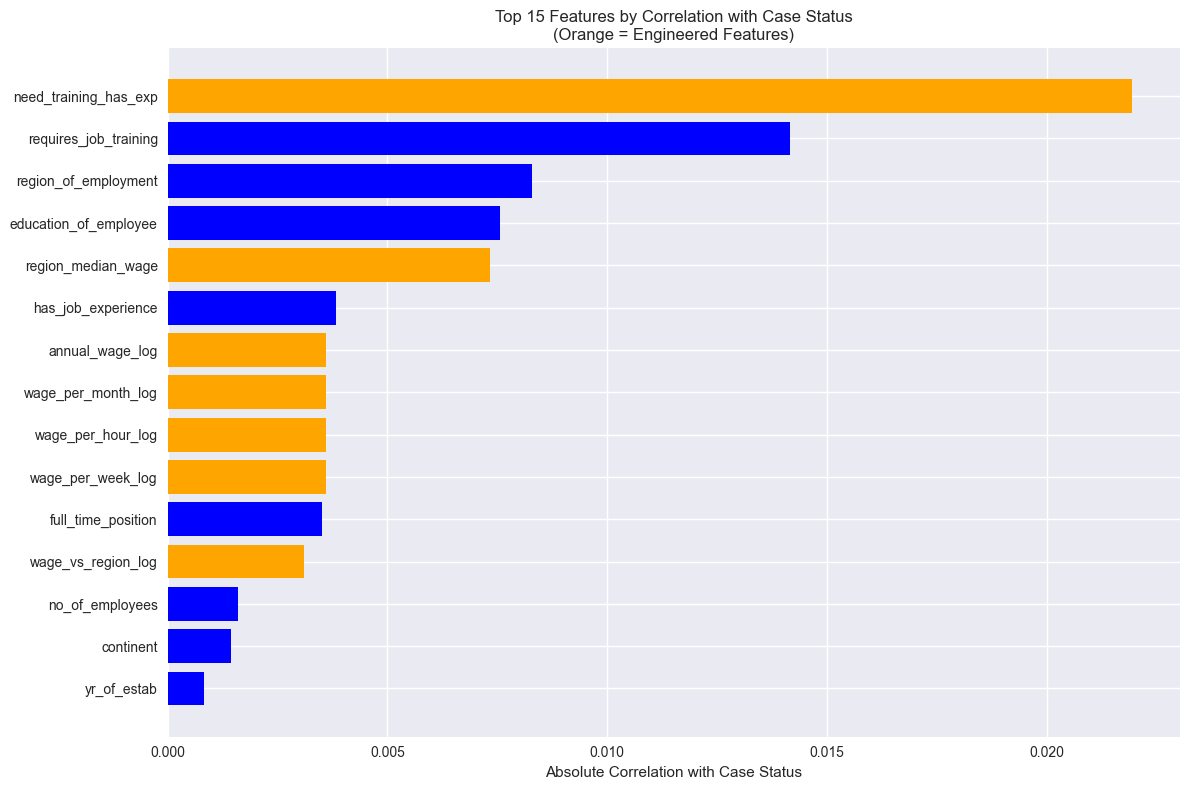


✓ Feature importance analysis completed
✓ 6 engineered features in top 10


In [28]:
# Feature importance analysis to validate EDA-based engineering
print("===FEATURE IMPORTANCE ANALYSIS===")

# Calculate correlation with target for all features
features_corr = X_train_scaled.corrwith(y_train).abs().sort_values(ascending=False)

print("Top 10 features by correlation with Case Status")
for i, (feature, corr) in enumerate(features_corr.head(10).items(), 1):
    print(f"{i:2d}. {feature}: {corr:.3f}")

# Check if engineered features are among top features
engineered_features = [col for col in X_train_scaled.columns if any(keyword in col.lower() for keyword in ['need', 'wage', 'log'])]
print(f"\nEngineered features in top 10: {[f for f in engineered_features if f in features_corr.head(10).index]}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = features_corr.head(15)
colors = ['orange' if any(keyword in f.lower() for keyword in ['need', 'wage', 'log']) else 'blue' for f in top_features.index]

plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Case Status')
plt.title('Top 15 Features by Correlation with Case Status\n(Orange = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✓ Feature importance analysis completed")
print(f"✓ {len([f for f in engineered_features if f in features_corr.head(10).index])} engineered features in top 10")

#### **8. Save Preprocessed Data**

Save all preprocessed dataset and preprocessing objects for modeling

In [29]:
print("SAVING PREPROCESSED DATA")

# Save the scaled datasets (features)
X_train_scaled.to_csv('Scaled_X_train.csv', index=False)
X_test_scaled.to_csv('Scaled_X_test.csv', index=False)


# Save the target variables
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Save preprocessing objects
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X.columns.tolist(), 'selected_features.pkl')

# Save preprocessing objects
feature_importance_df = pd.DataFrame({'feature': features_corr.index, 'correlation': features_corr.values})
feature_importance_df.to_csv('feature_importance.csv', index=False)

# Save Preprocessing summary
preprocessing_summary = {
    'original_shape': df_visa.shape,
    'final_shape': df_processed.shape,
    'selected_features': X.columns.tolist(),
    'engineered_features': engineered_features,
    'train_samples': X_train_scaled.shape[0],
    'test_samples': X_test_scaled.shape[0],
    'scaling_method': 'RobustScaler',
    'outlier_treatment': 'log Transformation',
    'log_transformed': ['annual_wage','wage_per_hour','wage_per_week', 'wage_per_month', 'age_of_estab', 'wage_vs_region']
}

import json
with open('preprocessing_summary.json', 'w') as f:
    json.dump(preprocessing_summary, f, indent=2)

print("- Preprocessed data saved successfully!")
print("\nFiles created:")
print("- X_train_scaled.csv, X_test_scaled.csv")
print("- y_train.csv, y_test.csv")
print("- scaler.pkl, selected_features.pkl")
print("- feature_importance.csv, preprocessing_summary.json")

SAVING PREPROCESSED DATA
- Preprocessed data saved successfully!

Files created:
- X_train_scaled.csv, X_test_scaled.csv
- y_train.csv, y_test.csv
- scaler.pkl, selected_features.pkl
- feature_importance.csv, preprocessing_summary.json


#### **9. Preprocessing Summary**


In [31]:
# Final preprocessing summary
print(".....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....")
print(f"Original dataset shape: {df_visa.shape}")
print(f"Final processed dataset shape: {df_processed.shape}")
print(f"Selected features: {len(X)}")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")

print("\n.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....")
print("> Data quality assessment (no missing values, no duplicated values)")
print("> Log-transformation of skewed variables ('annual_wage','wage_per_hour','wage_per_week', 'wage_per_month', 'age_of_estab', 'wage_vs_region')")
print("> Feature engineering based on EDA recommendations:")
print("- age_of_estab")
print("- annual_wage (wage_per_hour, wage_per_week, wage_per_month, wage_per_year)")
print("- need_training_has_exp")
print("- need_training_no_exp")
print("- region_median_wage")
print("- wage_vs_region.")
print("> Feature selection ('annual_wage','wage_per_hour','wage_per_week', 'wage_per_month', 'age_of_estab', 'wage_vs_region')")
print("> SMOTE (Handles class imbalance)")
print("> RobustScaler applied (EDA recommendation)")
print("> Feature importance analysis (validates engineered features)")
print("> Data export (ready for modeling)")

print("\n.....EDA EVIDENCE IMPLEMENTED.....")
print("> Skewed variables log-transformed as recommended")
print("> Features have been engineered")



print(f"\n Preprocessing completed successfully!!!!!!")
print(".....Ready for modeling phase with EDA-informed preprocessing")


.....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....
Original dataset shape: (25480, 11)
Final processed dataset shape: (25480, 26)
Selected features: 34036
Training samples: 27228
Test samples: 6808

.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....
> Data quality assessment (no missing values, no duplicated values)
> Log-transformation of skewed variables ('annual_wage','wage_per_hour','wage_per_week', 'wage_per_month', 'age_of_estab', 'wage_vs_region')
> Feature engineering based on EDA recommendations:
- age_of_estab
- annual_wage (wage_per_hour, wage_per_week, wage_per_month, wage_per_year)
- need_training_has_exp
- need_training_no_exp
- region_median_wage
- wage_vs_region.
> Feature selection ('annual_wage','wage_per_hour','wage_per_week', 'wage_per_month', 'age_of_estab', 'wage_vs_region')
> SMOTE (Handles class imbalance)
> RobustScaler applied (EDA recommendation)
> Feature importance analysis (validates engineered features)
> Data export (ready for modeling)

.....EDA EVI